1. 从零开始实现基于NumPy和SciPy包的预期改进获取函数
2. 使用一个现成的BO包来完成相同的任务

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
%matplotlib inline



In [2]:
# Define the objective function and search domain 
bounds = np.array([[-1.0, 2.0]])
noise = 0.02

# Objective function
def f(x, noise=0):
    return -np.sin(3*x) - x**2 + 0.7*x + noise * np.random.randn(*x.shape)



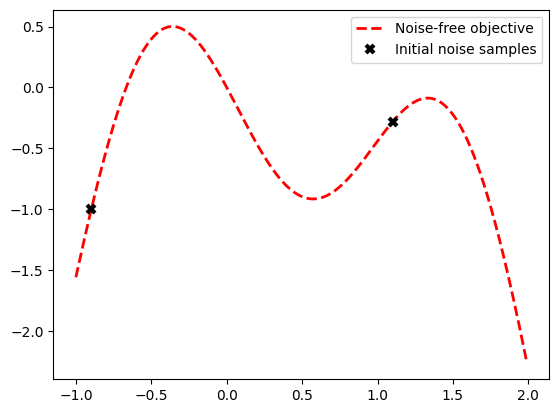

In [3]:
# Visualize the noise-free objective function
X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init, noise=noise)

X_plot = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
Y_plot = f(X_plot, noise=0)
plt.plot(X_plot, Y_plot, 'r--', lw=2, label='Noise-free objective')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial noise samples')
plt.legend()

In [4]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''

    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)
    sigma = sigma.reshape(-1, 1)

    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    mu_sample_opt = np.max(mu_sample)


    # np.errstate 是一个上下文管理器，用于临时改变NumPy的警告设置。在这里，divide='warn' 表示如果发生除以零的操作，NumPy将发出警告而不是错误。
    with np.errstate(divide='warn'):
        # 改进量的计算 xi是一个很小的值，避免分母为0
        imp = mu - mu_sample_opt - xi 
        # Z是标准化的改进量（改进量除以标准差）
        Z = imp / sigma
        
        """
        EI的计算: 两部分相加得到一个全面的预期改进量
        imp * norm.cdf(Z)：概率加权的改进量
        这部分计算的是，如果新点的目标函数值确实比当前最佳值好，那么这种改进量的期望值是多少。
        这里，norm.cdf(Z) 给出了新点目标函数值超过当前最佳值的概率，而 imp 是这种改进量的大小。
        将两者相乘，我们得到了在新点找到更好解的预期概率加权改进量。

        sigma * norm.pdf(Z)：概率密度加权的改进量 
        这部分计算的是，即使新点的目标函数值没有超过当前最佳值，它仍然有可能在当前最佳值附近。
        norm.pdf(Z) 给出了新点目标函数值在当前最佳值附近的概率密度，而 sigma 是目标函数值的不确定性（标准差）。
        将两者相乘，我们得到了在新点目标函数值接近当前最佳值时的预期改进量。

        """
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma[0][0] == 0.0] = 0.0 # 检查标准差（sigma）是否为零。如果为零，说明目标函数的方差非常小，或者函数是确定性的，因此不可能有改进。在这种情况下，Expected Improvement 被设置为零，因为没有任何改进的空间。

    return ei[0]

IndexError: boolean index did not match indexed array along dimension 1; dimension is 300 but corresponding boolean dimension is 1
```ei[sigma == 0.0] = 0.0    ```

sigma = array([[0.21732764]]) 所以改成 ei[sigma[0][0] == 0.0] = 0.0

In [9]:
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        bounds: Bounds of the variable.
        n_restarts:  为了避免Local optima，我们可以多次随机初始化优化算法的起始点。
    
    Returns:
        Location of the acquisition function maximum.
    '''
    
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    #使用了SciPy库中的minimize函数来执行优化任务。代码的目的是找到给定目标函数（min_obj）的最小值，同时考虑到变量的边界约束。
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        # np.random.uniform在这个边界内均匀地随机生成n_restarts个初始点，每个点有dim个变量。
        # bounds[:, 0]和bounds[:, 1]分别定义了每个变量的最小值和最大值，这些值构成了优化问题的边界约束。
        # 在 "L-BFGS-B" 中，"B" 代表 "Box"，意味着这个算法被设计来处理带有边界约束的优化问题。在这种情况下，变量的取值范围被限制在一个盒子（或称为超立方体）内。
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')

        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x
            
    return min_x.reshape(-1, 1)

In [10]:
def plot_approximation(gpr, X_plot, Y_plot, X_sample, Y_sample,X_next=None, show_legend=False):
# 绘制高斯过程（GP）后验均值和95%置信区间，同时展示收集到的样本点和目标函数。   
    
    mu, std = gpr.predict(X_plot, return_std=True)
    # plot mean and 95% confidence interval)
    plt.fill_between( X_plot.ravel(), mu.ravel() + 1.96 * std, mu.ravel() - 1.96 * std, alpha=0.1)
    plt.plot(X_plot, Y_plot, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X_plot, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    # plot the next sampling location as vertical line
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X_plot, acq_value, X_next, show_legend=False):
    # 绘制整个域内的预期改进值，并标出最大改进值的位置。

    plt.plot(X_plot, acq_value, 'r-', lw=1, label='Acquisition function')
    # plot the next sampling location as vertical line
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()


def plot_convergence(X_sample, Y_sample, n_init=2):
    #绘制随着优化过程进行，连续采样位置之间的距离以及当前最优值。
    plt.figure(figsize=(12, 3))
    # focus on sampled queried by the optimization policy    
    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    # distance between consecutive sampling locations    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    # best observed value until the current time point    
    y_max = np.maximum.accumulate(y)

    # plot the distance between consecutive sampling locations    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')
    # plot the evolution of observed maximum so far    
    plt.subplot(1, 2, 2)
    plt.plot(r, y_max, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

In [11]:
bounds

array([[-1.,  2.]])

[0.62485453] -0.009204468511849952
[2.] -0.2665032027442433
[0.6248603] -0.009204468506329059
[2.] -0.2665032027442433
[2.] -0.2665032027442433
[2.] -0.2665032027442433
[2.] -0.2665032027442433
[-0.57966047] -1.4726708444294493e-10
[2.] -0.2665032027442433
[0.62484632] -0.009204468515292264
[2.] -0.2665032027442433
[2.] -0.2665032027442433
[2.] -0.2665032027442433
[-0.93259208] -3.593818532050554e-205
[2.] -0.2665032027442433
[0.62490264] -0.009204468387537603
[0.62497387] -0.009204467876825544
[0.62484523] -0.009204468515359193
[-0.58193178] -1.1584211179142006e-10
[2.] -0.2665032027442433
[2.] -0.2665032027442433
[0.62475144] -0.009204468179185972
[-0.48496214] -1.601232005567097e-07
[2.] -0.2665032027442433
[-0.94482797] -1.6494467562651215e-162
[0.3381751] -0.678458608980472
[0.33818114] -0.678458609001197
[1.35393803] -0.12044744127207438
[0.33818097] -0.6784586090011868
[-1.] -0.004046959856836688
[0.3381798] -0.67845860900021
[1.35393723] -0.1204474412735744
[0.3381811] -0.67845

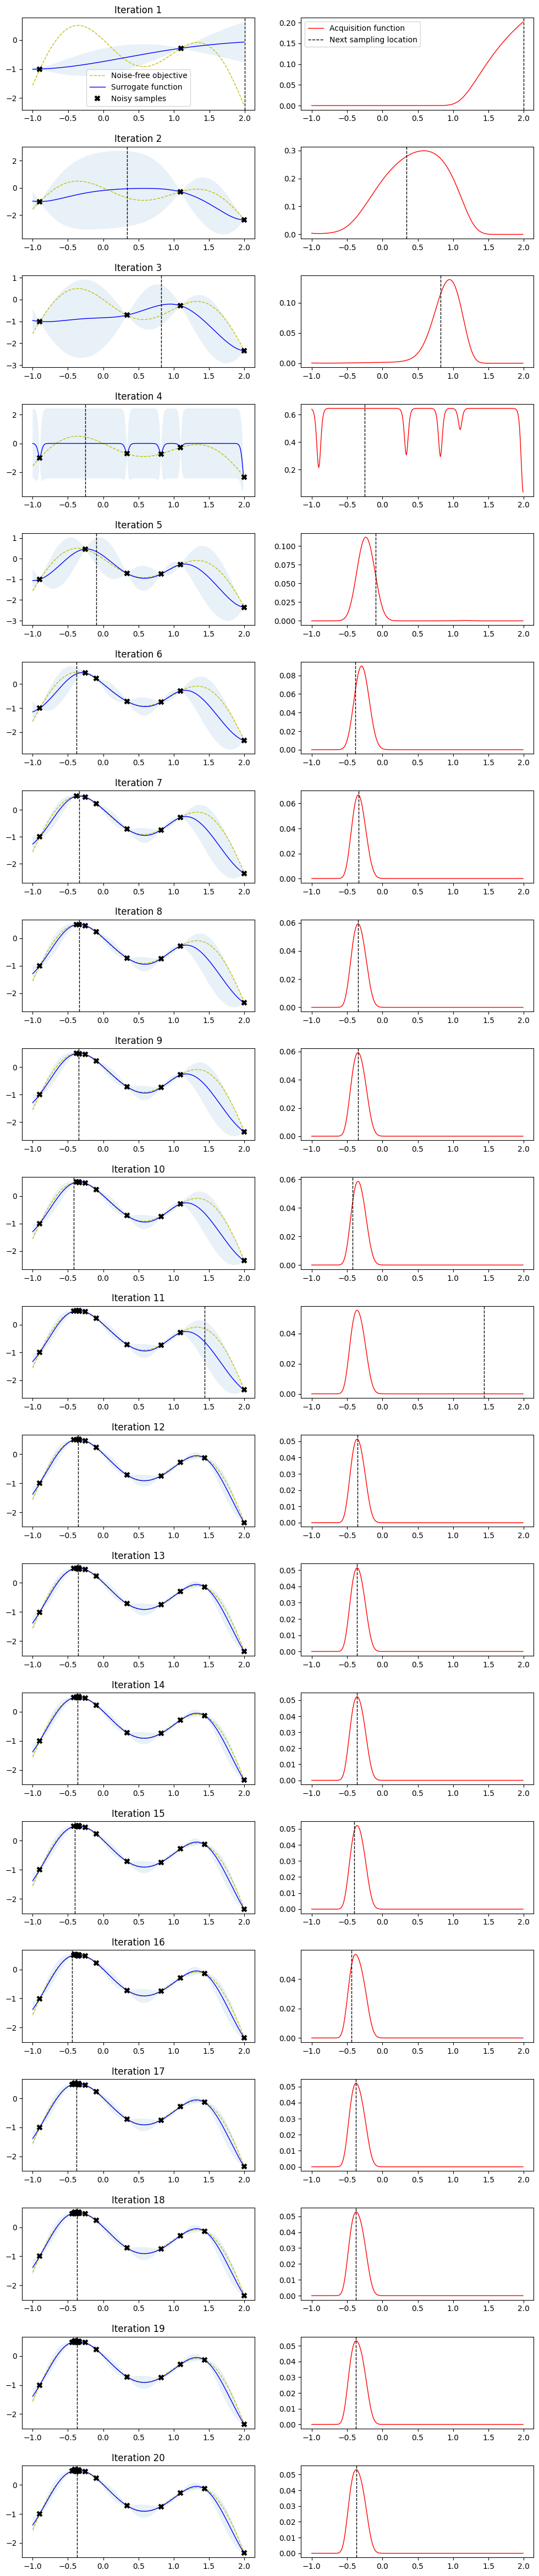

In [12]:
# Gaussian process with Matern kernel as surrogate model# kernel parameters could be optimized using MLE
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
# specify observation noise term, assumed to be known in advance
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)
# initial samples before optimization starts
X_sample = X_init
Y_sample = Y_init
# number of optimization iterations 
n_iter = 20

# specify figure size
plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)
#start of optimization
for i in range(n_iter):
    # update GP posterior given existing samples    
    gpr.fit(X_sample, Y_sample) 
    
    # obtain next sampling point from the acquisition function (expected_improvement)    
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    # obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
  
    # plot samples, surrogate function, noise-free objective and next sampling location    
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X_plot, Y_plot, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')
    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X_plot, expected_improvement(X_plot, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    # append the additional sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

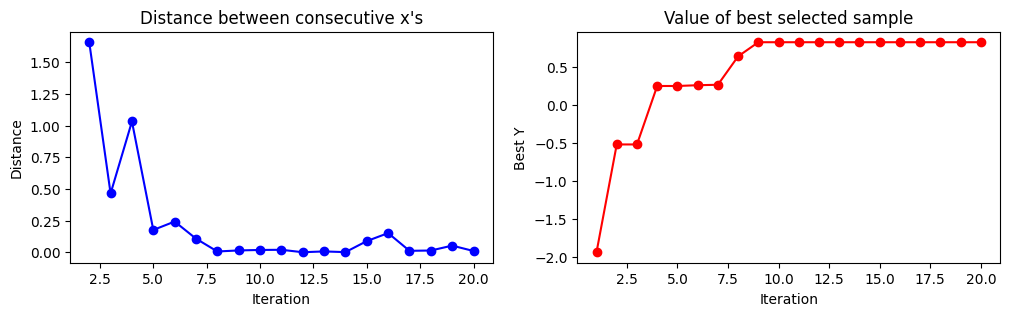

In [8]:
plot_convergence(X_sample, Y_sample, n_init=X_init.shape[0])

# OPTIMIZE

In [9]:
# !pip install scikit-optimize

/Users/xuhuizhi/anaconda3/envs/nn3.10/lib/python3.10/site-packages/skopt/space/space.py:110: UserWarning: Dimension [-1.0, 2.0] was inferred to Real(low=-1.0, high=2.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(-1.0, 2.0), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(


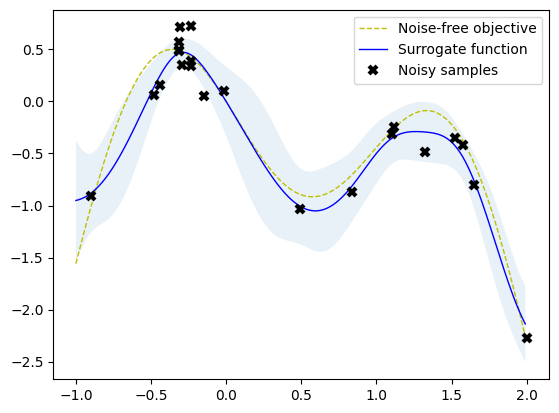

In [10]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

# use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
g = GaussianProcessRegressor(kernel=m52, alpha=noise**2)
# start BO
r = gp_minimize(func=lambda x: -f(np.array(x), 
                noise=noise)[0], # function to minimize
                dimensions=bounds.tolist(),    # search bounds
                base_estimator=g, # GP prior
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=n_iter,    
                # number of iterations
                n_initial_points=0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())
# fit GP model to samples for plotting
gpr.fit(r.x_iters, -r.func_vals)
# Plot the fitted model and the noisy samples
plot_approximation(gpr, X_plot, Y_plot, r.x_iters, -r.func_vals, show_legend=True)

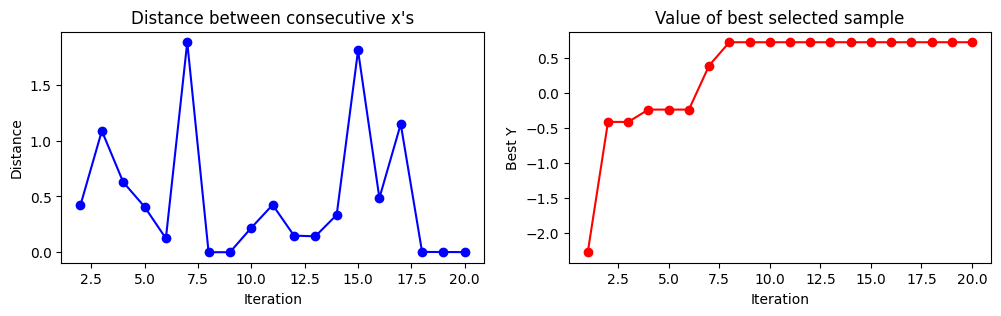

In [11]:
plot_convergence(np.array(r.x_iters), -r.func_vals)